1) 데이터 로드: seaborn 'diamonds'
   - 데이터 형태: (53940, 10)
2) 데이터 분할: 학습 (43152, 9), 테스트 (10788, 9)
3) 모델 학습 및 평가 진행
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1295
[LightGBM] [Info] Number of data points in the train set: 43152, number of used features: 23
[LightGBM] [Info] Start training from score 3939.490707
   - LightGBM   | MSE: 312,872.18 | R2: 0.9803 | fit: 0.28s
   - XGBoost    | MSE: 335,947.78 | R2: 0.9789 | fit: 42.52s
   - CatBoost   | MSE: 309,000.27 | R2: 0.9806 | fit: 6.04s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1295
[LightGBM] [Info] Number of data points in the train set: 43152, number of used features: 23
[LightGB

,Model,MSE,R2,FitSeconds
0,Stacking,297792.424336,0.981267,169.963670
1,CatBoost,309000.265012,0.980562,6.038890
2,LightGBM,312872.178065,0.980319,0.276761
3,XGBoost,335947.781250,0.978867,42.522886


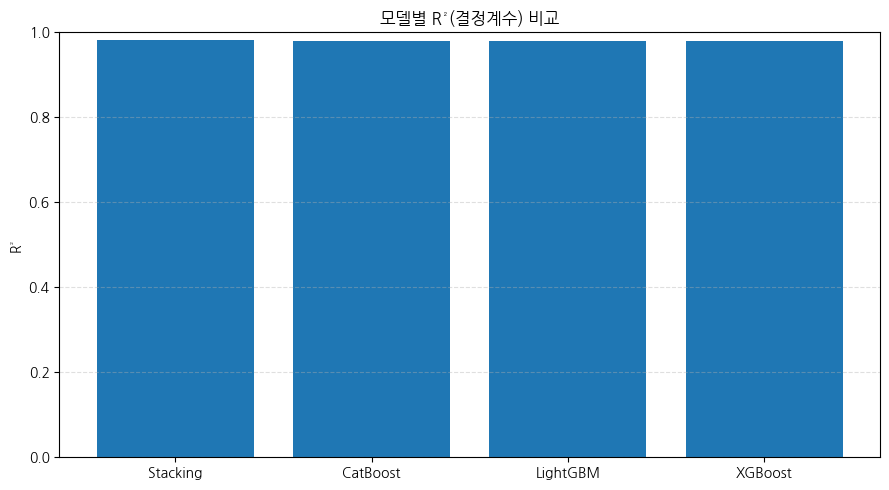

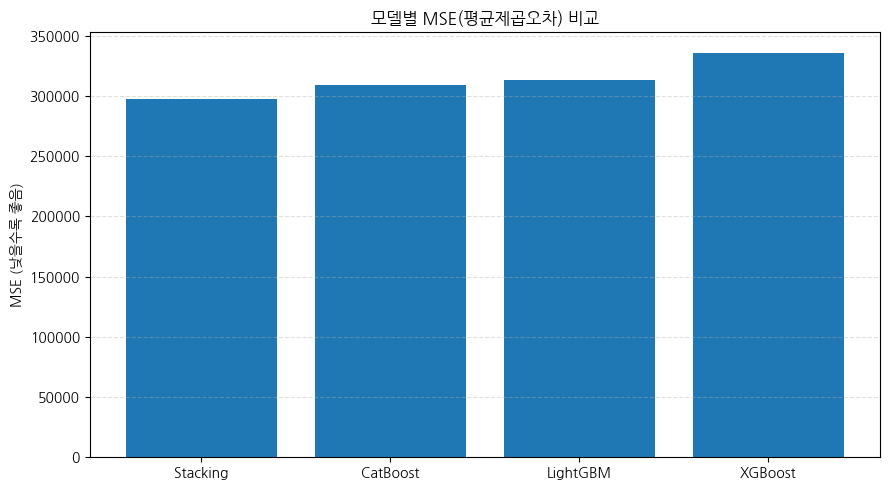

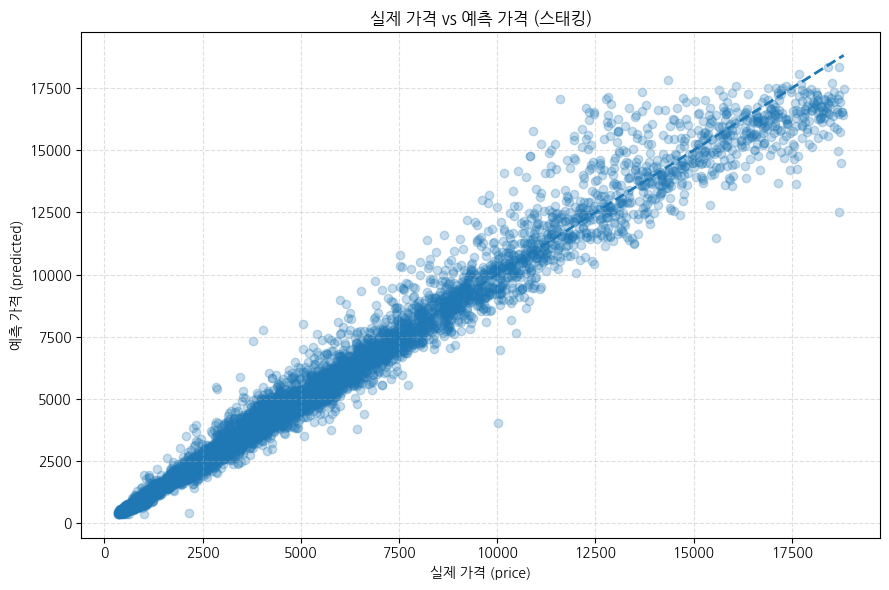

In [1]:
# ------------------------- [시각화 폰트(한글) 세팅] -------------------------
import matplotlib.pyplot as plt  # 그래프 그리기
import platform  # 운영체제 감지

# OS별 폰트 지정 (리눅스: 나눔고딕 / 맥: 애플고딕 / 윈도우: 맑은고딕)
if platform.system() == 'Linux':
    plt.rcParams['font.family'] = 'NanumGothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# ------------------------- [필요 라이브러리 임포트] -------------------------
import warnings; warnings.filterwarnings('ignore')  # 경고 숨김(선택)
import time  # 간단한 속도 측정
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# ------------------------- [1) 데이터 로드] -------------------------
# seaborn의 diamonds는 최초 1회 인터넷에서 받아 로컬에 캐시됨.
# 오프라인 상황 대비: 실패하면 에러 메시지 안내.
try:
    print("1) 데이터 로드: seaborn 'diamonds'")
    diamonds = sns.load_dataset('diamonds')
except Exception as e:
    raise RuntimeError("diamonds 데이터셋을 불러오지 못했습니다. 인터넷 연결 또는 seaborn 버전을 확인하세요.") from e

print(f"   - 데이터 형태: {diamonds.shape}")  # (행, 열)

# ------------------------- [2) 입력/타깃 분리 + 전처리 정의] -------------------------
# 타깃(y): price, 입력(X): 나머지
y = diamonds['price']
X = diamonds.drop('price', axis=1)

# 범주형 / 수치형 컬럼 지정
categorical_features = ['cut', 'color', 'clarity']
numerical_features   = ['carat', 'depth', 'table', 'x', 'y', 'z']

# ColumnTransformer: 수치형→표준화, 범주형→원-핫 인코딩
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
    ],
    remainder='drop'  # 지정한 컬럼만 사용
)

# ------------------------- [3) 학습/테스트 분리] -------------------------
# 재현성 위해 random_state 고정, 8:2 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"2) 데이터 분할: 학습 {X_train.shape}, 테스트 {X_test.shape}")

# ------------------------- [4) 개별 모델 정의] -------------------------
# 실행 속도가 느리면 XGB의 n_estimators를 줄이면 빨라짐(예: 100)
XGB_N_ESTIMATORS = 100  # ← 필요 시 300, 500 등으로 조정 가능

# 각 모델을 동일한 전처리 파이프라인과 묶어서 '공정 비교'
pipe_lgbm = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', lgb.LGBMRegressor(random_state=42))
])

pipe_xgb = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', xgb.XGBRegressor(random_state=42, n_estimators=XGB_N_ESTIMATORS))
])

pipe_cat = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', CatBoostRegressor(verbose=0, random_state=42))
])

# 스태킹: 위 3개 예측을 메타 모델(선형회귀)로 종합
stack = Pipeline(steps=[
    ('pre', preprocessor),
    ('reg', StackingRegressor(
        estimators=[
            ('lgbm', lgb.LGBMRegressor(random_state=42)),
            ('xgb',  xgb.XGBRegressor(random_state=42, n_estimators=XGB_N_ESTIMATORS)),
            ('cat',  CatBoostRegressor(verbose=0, random_state=42))
        ],
        final_estimator=LinearRegression(),
        cv=3
    ))
])

# ------------------------- [5) 학습 + 평가 함수(중복 줄이기)] -------------------------
def fit_and_eval(model, name):
    """모델 학습 후 MSE, R2, 학습시간을 반환"""
    start = time.time()               # 시작 시간
    model.fit(X_train, y_train)       # 학습
    secs = time.time() - start        # 학습 소요 시간(초)
    y_pred = model.predict(X_test)    # 예측
    mse = mean_squared_error(y_test, y_pred)  # MSE
    r2  = r2_score(y_test, y_pred)            # R2
    print(f"   - {name:10s} | MSE: {mse:,.2f} | R2: {r2:.4f} | fit: {secs:.2f}s")
    return name, mse, r2, secs, y_pred

print("3) 모델 학습 및 평가 진행")
results = []
preds = {}

# 개별 모델들
for name, mdl in [
    ('LightGBM', pipe_lgbm),
    ('XGBoost',  pipe_xgb),
    ('CatBoost', pipe_cat),
]:
    n, mse, r2, secs, yhat = fit_and_eval(mdl, name)
    results.append((n, mse, r2, secs))
    preds[n] = yhat

# 스태킹
n, mse, r2, secs, yhat = fit_and_eval(stack, 'Stacking')
results.append((n, mse, r2, secs))
preds[n] = yhat

# ------------------------- [6) 결과 표로 정리] -------------------------
df_results = pd.DataFrame(results, columns=['Model', 'MSE', 'R2', 'FitSeconds'])
# 보기 좋게 정렬: R2 내림차순
df_results = df_results.sort_values('R2', ascending=False).reset_index(drop=True)
print("\n4) 모델별 성능 요약")
display(df_results)

# ------------------------- [7) 시각화 (막대그래프)] -------------------------
plt.figure(figsize=(9, 5))
# R2 막대그래프
plt.bar(df_results['Model'], df_results['R2'])
plt.title("모델별 R²(결정계수) 비교")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# MSE 막대그래프 (낮을수록 좋음)
plt.figure(figsize=(9, 5))
plt.bar(df_results['Model'], df_results['MSE'])
plt.title("모델별 MSE(평균제곱오차) 비교")
plt.ylabel("MSE (낮을수록 좋음)")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# ------------------------- [8) 산점도(실제 vs 예측) - 스태킹 기준] -------------------------
# 대각선 기준선과 비교 → 선에 가까울수록 정확
y_pred_stack = preds['Stacking']
plt.figure(figsize=(9, 6))
plt.scatter(y_test, y_pred_stack, alpha=0.25)
min_val, max_val = y_test.min(), y_test.max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', linewidth=2)
plt.title("실제 가격 vs 예측 가격 (스태킹)")
plt.xlabel("실제 가격 (price)")
plt.ylabel("예측 가격 (predicted)")
plt.grid(axis='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
